
# Project 1: Digit Classification with KNN


# Intro
---
In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b> To be safe, please credit any sources used.


## Grading
---
 - Make sure to answer every part in every question.
 - There are 5 questions, each worth an equal number of points.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean or is not well commented
   - the functions or answers are excessively long

## Requirements:
---
1. Comment your code.
1. Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning, keep things inside functions).

## Additional reading and notes
---

If you are looking to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

Additionally, if you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.23.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Visualize a select sample of images
---
Show a 10x10 grid that visualizes 10 examples of each digit.

Notes:
* Make the digits nice and big.
* You can use `plt.rc()` for setting the colormap, for example to black and white.
* You can use `plt.subplot()` for creating subplots.
* You can use `plt.imshow()` for rendering a matrix.
* You can use `np.array.reshape()` for reshaping a 1D feature vector into a 2D matrix (for rendering).

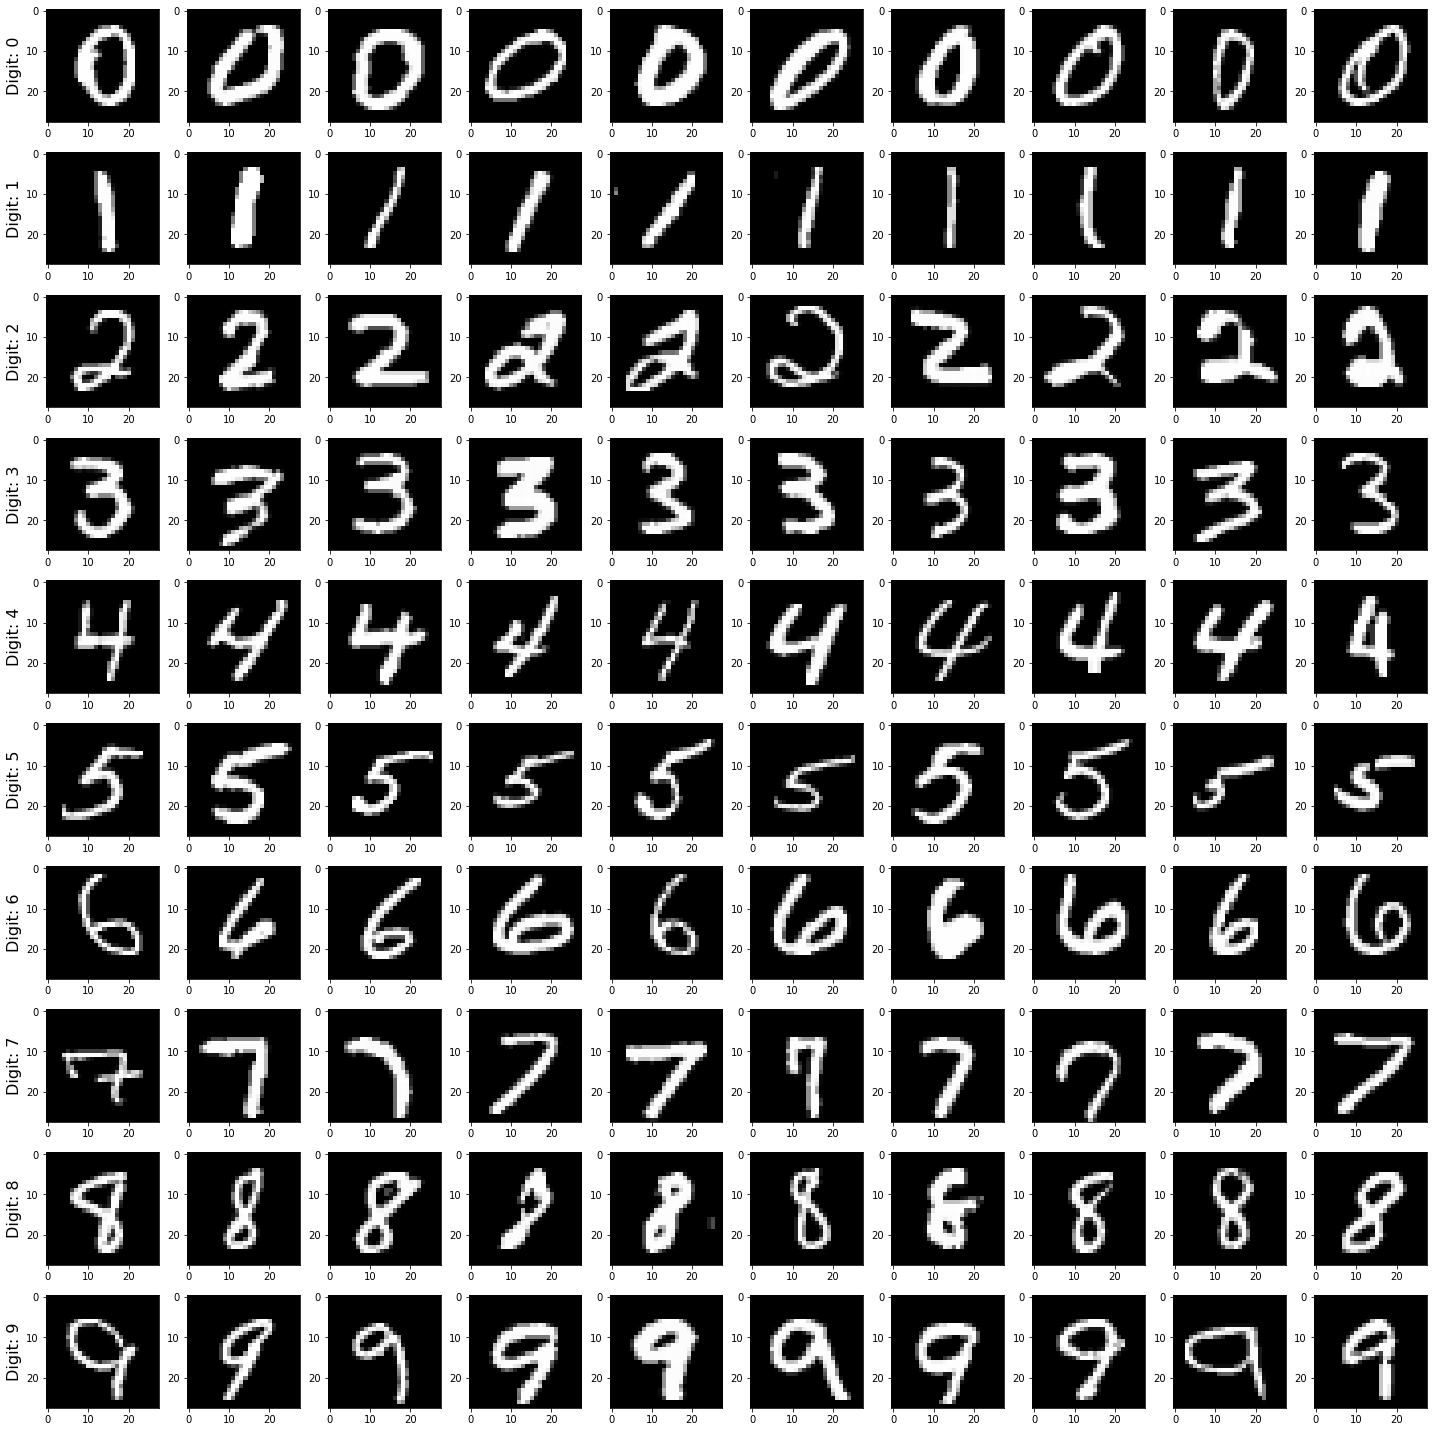

In [4]:
def Q1(num_examples=10):
  ### STUDENT START ###
    ''' The function takes in number of instances/examples for each digit to 
    be printed. The logic is to walk through label variable Y, check for the
    label value, the digit, and record the index in Y for that digit in a
    dictionary. This dictionary is indexed by the digit, and for each digit, the
    key of the dictionary, the index value in the label Y is stored. 
    
    The dictionary is then used to index the image/pixels row in the X variable
    and render that on a num_exapmles x 10 grid.
    
    Given that we're used shuffled data from what is read from mnist_784 we get 
    a good random sample of 10 for each of the digits.
    '''
    # initialize counters and dictionary
    digit_count = 0
    label_ind = 0
    dict_digit_ind = {}
    for i in range(10): 
        dict_digit_ind[str(i)] = []
    
    while label_ind < Y.shape[0]: # while we've elements to process in Y
        digit = Y[label_ind]
        
        if len(dict_digit_ind[digit]) < 10: # if number of indices accumulated is < 10
            dict_digit_ind[digit].append(label_ind) # append the label index
            digit_count += 1 # increment the number of digits counter
        
        if digit_count < num_examples * 10: # if number of indices is < 10 x num_examples 
            label_ind += 1
        else: # if the number of digits indices accumulates >= 100 break the while loop
            break
    
    #create the needed subplot - 10 rows, 1 for each digit
    fig, axes = plt.subplots(nrows=10, ncols=num_examples, figsize=(20, 20))
    
    for key in dict_digit_ind.keys(): # for each key (digit)
        for val in dict_digit_ind[key]: # iterate through the list of all its indices in X
            digit_px = X[val]
            digit_px_image = digit_px.reshape(28, 28) # reshape the pixel values to 28x28 grid
            ax = axes[int(key), dict_digit_ind[key].index(val)] # row = key/digit, column = index in the list
            ax.imshow(digit_px_image, cmap="gray") # display the image
            if dict_digit_ind[key].index(val) == 0: 
                ax.set_ylabel('Digit: ' + key, fontsize=16)

    fig.tight_layout()
    plt.show()
    
  ### STUDENT END ###

Q1(10)

### Question 2: Evaluating different choices of k
---

1. Produce k-Nearest Neighbors models with k = 1, 3, 5, 7, and 9.  
1. Print the accuracy of each model. 
1. Additionally, only for the 1-Nearest Neighbor model, show the precision, recall, and F1 for each label. 
1. Which digit is the most *difficult* for the 1-Nearest Neighbor model to classify correctly? How did you choose and why?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Print only the information asked so it is easy to read and compare.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `classification_report` to get precision, recall, and F1 results.
* Check out what the function "score" does.

In [5]:
def Q2(k_values):

### STUDENT START ###
    for k_val in k_values:
        classifier = KNeighborsClassifier(n_neighbors=k_val) # init classifier for a specific KNN
        classifier.fit(mini_train_data, mini_train_labels) # train the classifier
        y_pred = classifier.predict(dev_data) # generate predicted values from test data
        print("Number of neighors in KNN:", k_val)
        r = classification_report(dev_labels, y_pred, output_dict=True) # classification report
        print("           Accuracy: %0.3f" % r['accuracy'])
        if k_val == 1:
            print("              precision    recall  f1-score")
            print()
            for i in range(10):
                temp = r[str(i)]
                print("%12d %10.2f %9.2f %9.2f" % 
                      (i, temp['precision'], temp['recall'], temp['f1-score']))
        print()
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
Q2(k_values)

Number of neighors in KNN: 1
           Accuracy: 0.884
              precision    recall  f1-score

           0       0.95      0.95      0.95
           1       0.89      0.98      0.93
           2       0.90      0.79      0.84
           3       0.93      0.87      0.90
           4       0.91      0.85      0.88
           5       0.86      0.88      0.87
           6       0.92      0.92      0.92
           7       0.85      0.94      0.89
           8       0.83      0.77      0.80
           9       0.80      0.86      0.83

Number of neighors in KNN: 3
           Accuracy: 0.876

Number of neighors in KNN: 5
           Accuracy: 0.882

Number of neighors in KNN: 7
           Accuracy: 0.877

Number of neighors in KNN: 9
           Accuracy: 0.875



#### Answer to part 4: 
Looking at the results of the 1-Nearest Neighbor model it appears that *digit 8* is the most difficult one to classify. 

The recall score of digit 8 is 0.77; recall score tells the fraction of positives that were correctly identified. The digit 8 scores the lowest in the recall score. Then, if we look af f1-score, again digit 8 has the lowest score. The f1-score is the weighted harmonic mean of precision and recall. 

The formula for f1-score is {2 * (precision * recall) / (precision + recall)}. 

The lower the f1-score the less accurate the classification is.

### Question 3: Examining the importance of training size
---
1. Produce 1-Nearest Neighbor models using training data of various sizes. For example, ```train_data[:train_size]```.
1. Evaluate and show the accuracy achieved by each model.  
1. Show the time needed to: 
  1. Train each model.
  1. Measure the accuracy of each model.
1. What do you see? Is this what you expected to see and why?
1. Plot on the same graph (as a function of training size):
  1. the time needed for training
  1. the time needed for calculating accuracy

Notes:
* Evaluate on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `time.time()` to measure elapsed time of operations.

Train data size: 100
       Train time:  0.0021811seconds
       Eval time:  0.1992819seconds
       Accuracy: 0.702

Train data size: 200
       Train time:  0.0030119seconds
       Eval time:  0.3124151seconds
       Accuracy: 0.791

Train data size: 400
       Train time:  0.0054913seconds
       Eval time:  0.5092769seconds
       Accuracy: 0.811

Train data size: 800
       Train time:  0.0137501seconds
       Eval time:  1.2673070seconds
       Accuracy: 0.866

Train data size: 1600
       Train time:  0.0538199seconds
       Eval time:  2.8627191seconds
       Accuracy: 0.905

Train data size: 3200
       Train time:  0.1546059seconds
       Eval time:  4.9748449seconds
       Accuracy: 0.927

Train data size: 6400
       Train time:  0.3084950seconds
       Eval time:  8.5755160seconds
       Accuracy: 0.939

Train data size: 12800
       Train time:  1.0172291seconds
       Eval time: 17.5806301seconds
       Accuracy: 0.952

Train data size: 25600
       Train time:  5.076437

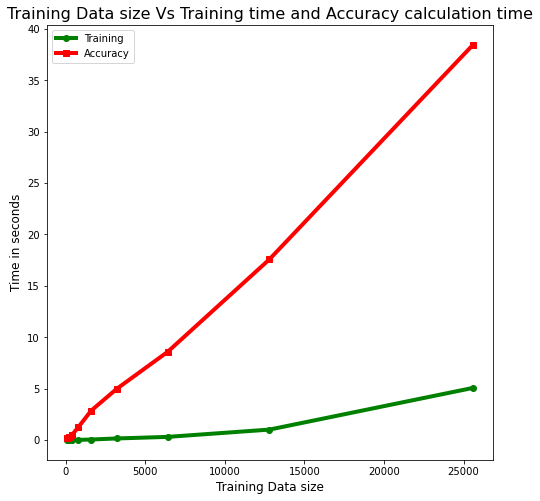

In [6]:
def Q3(train_sizes, accuracies):

### STUDENT START ###
    for num in train_sizes:
        classifier = KNeighborsClassifier(n_neighbors=1) # init classifier for a 1-NN
        
        start = time.time()
        classifier.fit(train_data[:num], train_labels[:num]) # train with a specific amount of data
        train_time = time.time() - start
        train_times.append(train_time)
        
        start = time.time()
        y_pred = classifier.predict(dev_data) # generate predicted values from test data
        r = classification_report(dev_labels, y_pred, output_dict=True) # classification report
        eval_time = time.time() - start
        eval_times.append(eval_time)
        accuracies.append(r['accuracy'])
        
        print("Train data size:", num)
        print("       Train time: %10.7fseconds" % train_time)
        print("       Eval time: %10.7fseconds" % eval_time)
        print("       Accuracy: %0.3f" % r['accuracy'])
        print()
    
    plt.figure(figsize=(8, 8))
    plt.xlabel("Training Data size", fontsize=12)
    plt.ylabel("Time in seconds", fontsize=12)
    plt.plot(train_sizes, train_times, 'g-o', linewidth=4, label = 'Training')
    plt.plot(train_sizes, eval_times, 'r-s', linewidth =4, label = 'Accuracy')
    plt.legend()
    plt.title("Training Data size Vs Training time and Accuracy calculation time", fontsize=16)       
### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
accuracies = []
train_times = []
eval_times = []
Q3(train_sizes, accuracies)

#### Answer to part 4:
The accuracy of the result does go up with the amount of training data used to train the model. In fact, we see a tad over 90% accuracy at 1600. After that, accuracy goes up by a little over 1% for every doubling of the training data size. This is definitely expected. The more the number of data points on which to model the more machine gets trained. This seems to be a fundamental tenet of supervised training.

Note that the time takes to get the accuracy calculation goes up at a much higher rate. Training time also goes up. The slope of the time taken to calculate accuracy is probably about 3 to 4 times higher than that of training time. 

### Question 4: Evaluating if we should obtain additional data
---

In this question we wish to predict what accuracy we would get if we had additional training data.

Our input, our features and labels, are the output from the previous question. Based on the training size and accuracy we got in the previous question, we wish to predict the accuracy we would get if we had larger training sizes.

1. Produce a linear regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size. 
1. Print $R^2$ of the linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot on a lineplot graph:
  1. the actual accuracies we obtained in the previous question 
  1. and the accuracies our model predicted we would have gotten.
  1. The X axis is the training set size. 
  1. You can limit the range of X and Y to the range where you have data for both plots. Meaning, in the this question, we want to visualize how good the prediction is.
1. What are two things that are wrong with our model?
1. Apply a transformation to the predictor features and a transformation to the outcome that make the predictions fix these issues. 
1. Show $R^2$ of the improved linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot a lineplot graph of both again as before.
  1. Be sure to plot this where the Y axis is accuracy and X axis is training set size, **not the transformed space**!
  1. Choose the range of X and Y to visualize effectively.

Notes:
* Train the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* Evaluate the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* You can use `LinearRegression` to produce a linear regression model.
* Remember that the sklearn `fit()` functions take an input matrix X and output vector Y. So, each input example in X is a vector, even if it contains only a single value.
* Hints:
  1. You have two problems here, how well your model fits and predicting *illogical* values of accuracy.
  1. You can look at:
    1. [logit](https://en.wikipedia.org/wiki/Logit): $\frac{1}{1 + e^{-x}} = \frac{e^x}{1+e^x}$ which takes numbers in $\[\infty,-\infty\]$ and outputs numbers in $(0, 1)$.
    1. [logistic](https://en.wikipedia.org/wiki/Logistic_function): $log(\frac{p}{1 - p})$ which takes numbers between $(0, 1)$ and outputs numbers between $\[\infty,-\infty\]$.
    1. It also happens that $x = logistic(p)$ is the same thing as $logit(x)=p$.

Linear regression training:
         R^2: 0.4177006634161019
   Intercept: 0.8349182879377431
       slope: 6.687581380828008e-06

Accuracies fed into the linear model  : [0.702 0.791 0.811 0.866 0.905 0.927 0.939 0.952 0.963]
Linear regression predicted accuracies: [0.836 0.836 0.838 0.840 0.846 0.856 0.878 0.921 1.006]

Predicted accuracy for size 60000: 1.2362
Predicted accuracy for size 120000: 1.6374
Predicted accuracy for size 1000000: 7.5225

Linear regression training with log transformation:
         R^2: 0.8825621968324606
   Intercept: -0.5277709283378786
       slope: 0.052452658457214314

Transformed accuracies for the linear model: [-0.354 -0.234 -0.209 -0.144 -0.100 -0.076 -0.063 -0.049 -0.038]
Linear regression predicted accuracies     : [-0.286 -0.250 -0.214 -0.177 -0.141 -0.104 -0.068 -0.032 0.005]

Predicted accuracy for size 60000: 0.0493
Predicted accuracy for size 120000: 0.0857
Predicted accuracy for size 1000000: 0.1969


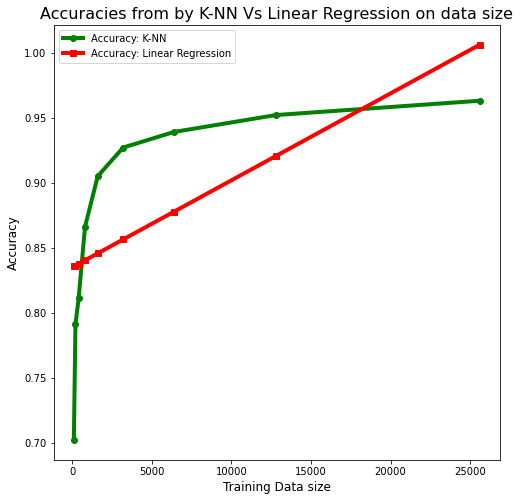

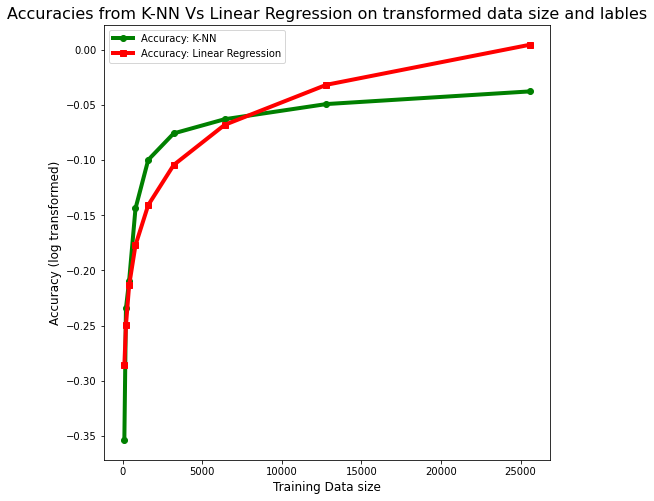

In [7]:
def Q4():

### STUDENT START ###
    train_size_x = np.array(train_sizes).reshape((-1, 1)) # cast train_sizes list into a matrix
    label_x = np.array(accuracies) # cast accuracies list into a vector
    
    model = LinearRegression().fit(train_size_x, label_x) # run the linear regression model
    
    # get the R^2, intercept, and slope
    r_sq = model.score(train_size_x,label_x) 
    b0 = model.intercept_
    b1 = model.coef_[0]
    
    print("Linear regression training:")
    print("         R^2:", r_sq)
    print("   Intercept:", b0)
    print("       slope:", b1)
    print()
    
    print("Accuracies fed into the linear model  :", label_x)
    
    predicted_accuracies = model.predict(train_size_x) # let the model predict on training data
    
    print("Linear regression predicted accuracies: [", end="")
    for i in range(len(predicted_accuracies)):
        if i == len(predicted_accuracies) - 1:
            print("%0.3f" % predicted_accuracies[i], end="")
        else:
            print("%0.3f" % predicted_accuracies[i], end=" ")
    print("]")
    print()
    
    test_sizes = [60000, 120000, 1000000]
        
    for i in test_sizes:
        y_pred2 = b0 + b1 * i # predict using the linear model
        print("Predicted accuracy for size", i, end="")
        print(": %1.4f" % y_pred2)
    print()
      
    # do the linear regression with log transformed data
    model_t = LinearRegression().fit(np.log(train_size_x), np.log(label_x)) # LM on transformed data
    
    # get the R^2, intercept, and slope
    r_sq_t = model_t.score(np.log(train_size_x), np.log(label_x)) 
    b0_t = model_t.intercept_
    b1_t = model_t.coef_[0]
    
    print("Linear regression training with log transformation:")
    print("         R^2:", r_sq_t)
    print("   Intercept:", b0_t)
    print("       slope:", b1_t)
    print()
    
    log_label_x = np.log(label_x)
    print("Transformed accuracies for the linear model: [", end="")
    for i in range(len(log_label_x)):
        if i == len(log_label_x) - 1:
            print("%0.3f" % log_label_x[i], end="")
        else:
            print("%0.3f" % log_label_x[i], end=" ")
    print("]")
    
    predicted_accuracies_t = model_t.predict(np.log(train_size_x)) # let the model predict on training data
    
    print("Linear regression predicted accuracies     : [", end="")
    for i in range(len(predicted_accuracies_t)):
        if i == len(predicted_accuracies_t) - 1:
            print("%0.3f" % predicted_accuracies_t[i], end="")
        else:
            print("%0.3f" % predicted_accuracies_t[i], end=" ")
    print("]")
    print()
          
    for i in test_sizes:
        y_pred2 = b0_t + b1_t * np.log(i) # note that the test sizes values are tranformed to log
        print("Predicted accuracy for size", i, end="")
        print(": %1.4f" % y_pred2)
    
    # plot for the case of accuracies when no transformation done
    plt.figure(figsize=(8, 8))
    plt.xlabel("Training Data size", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.plot(train_sizes, accuracies, 'g-o', linewidth=4, label = 'Accuracy: K-NN')
    plt.plot(train_sizes, predicted_accuracies, 'r-s', linewidth =4, label = 'Accuracy: Linear Regression')
    plt.legend()
    plt.title("Accuracies from by K-NN Vs Linear Regression on data size", fontsize=16) 
    
    # plot for the case of accuracies with transformation done
    plt.figure(figsize=(8, 8))
    plt.xlabel("Training Data size", fontsize=12)
    plt.ylabel("Accuracy (log transformed)", fontsize=12)
    plt.plot(train_sizes, np.log(accuracies), 'g-o', linewidth=4, label = 'Accuracy: K-NN')
    plt.plot(train_sizes, predicted_accuracies_t, 'r-s', linewidth =4, label = 'Accuracy: Linear Regression')
    plt.legend()
    plt.title("Accuracies from K-NN Vs Linear Regression on transformed data size and lables", fontsize=16) 
    
### STUDENT END ###


Q4()

#### Answer to part 5:  
The linear model we ran is based on the assumption that a linear relationship between accuracies of 1-NN model exits. Accuracy of a 1-NN model is related to the size of the sample. This is not entirely false. The larger sized sample does improve accuracy, as was seen in Q3.Thus, there are two questionable, likely wrong, assumptions here:
1. There is a linear relationship between the accuracy value of a 1-NN model and sample size. As the first of the plots above shows indeed it's more like square-root or log relationship between sample size and accuracy.
2. The accuracy is bounded between 0 and 1, and thus it may be more amenable to something like a logistic regression model driven by 1/(1+exp(-x)) function than a linear function.

The 1st plot clearly shows that there is no linear relationship between accuracy and traninig data size. Further, the last value in excess of 1 is an absurdity.

Upon applying log transformations the wide discrepancy from the earlier model is significantly reduced. The two models does converge at several points and the amount of deviation is vastly reduced.


### Question 5: Getting to know the confusion matrix.
---

1. Produce a 1-Nearest Neighbor model.
1. Show the confusion matrix. 
1. Which digit does the model most often confuse with which digit? (*for example, the model most often mistakes the digit $1$ as the digit $7$*).
1. Show examples of the misclassified digit.

Notes:
- Train on the mini train set.
- Evaluate performance on the dev set.
- You can use `confusion_matrix()` to produce a confusion matrix.
- No need to calculate the "most confused digits" programmatically.

The confusion matrix:
[[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]


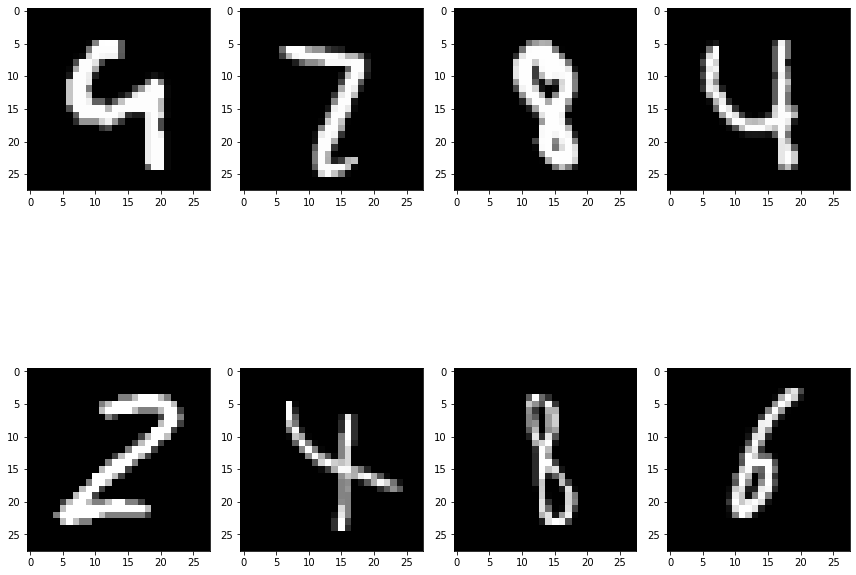

In [24]:
def Q5():

### STUDENT START ###
    classifier = KNeighborsClassifier(n_neighbors=1) # init classifier for 1-NN
    classifier.fit(mini_train_data, mini_train_labels) # train the classifier
    y_pred = classifier.predict(dev_data)
    cm = confusion_matrix(dev_labels, y_pred)
    print("The confusion matrix:")
    print(cm)
    rows = 0
    cols = 0
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 12))
    
    for i in range(len(y_pred)):
        if y_pred[i] != dev_labels[i]:
            digit_px = dev_data[i]
            digit_px_image = digit_px.reshape(28, 28)
            ax = axes[rows, cols]
            cols += 1
            ax.imshow(digit_px_image, cmap="gray")
        if rows == 1 and cols > 3:
            break
        if rows == 0 and cols == 4:
            rows += 1
            cols = 0
        
    fig.tight_layout()
    plt.show()       
### STUDENT END ###

Q5()


#### Answer to part 3: 
Looking at row number 4 (counting from row number 0), the largest number is 11 in that row, and that is also the largest number not on the diagonal. This means that the number 4 got interpreted as 9 11 times, which is the maximum any digit got mistaken for a different digit.

Thus, 4 being mistaken for 9 is the most confused case.